In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# PCA of spectra

To reproduce figure 3, we apply PCA to the spectra.

In [2]:
import logging

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from smelly_rats.loader import load_smelly_rats
from smelly_rats import modeling

logging.basicConfig(
    format='%(message)s',
    level=logging.INFO
)

In [3]:
hnmr_spectra, target = load_smelly_rats('../data/onion_NMR.mat')

In [4]:
def plot_pca(df, ax):
    symbols = ['s', 'o', '*', '<']
    for idx, (label, group_df) in enumerate(df.groupby('label')):
        group_df.plot(1, 0, style=symbols[idx], label=label, ax=ax, legend=False)
        
    ax.axhline(0, linestyle='--', color='gray', alpha=0.2)
    ax.axvline(0, linestyle='--', color='gray', alpha=0.2)
    
    x_values, y_values = df.iloc[:, 1], df.iloc[:, 0]
    x_max = np.abs(x_values).max()
    ax.set_xlim([-x_max, x_max])
    y_max = np.abs(y_values).max()
    ax.set_ylim([-y_max, y_max])
    return ax

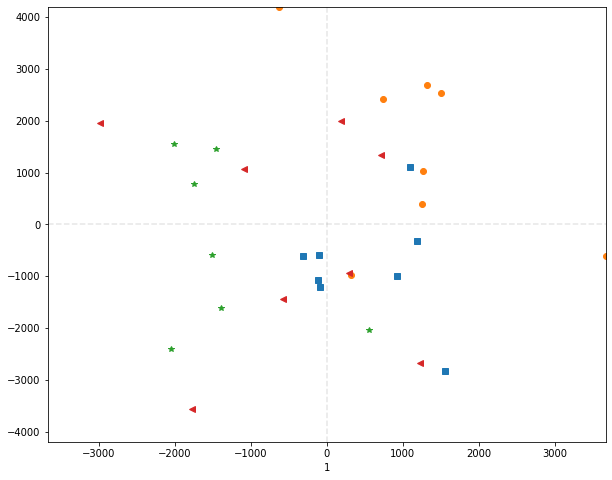

In [5]:
mod = Pipeline([
    ('scaler', modeling.ParetoScaler(with_mean=True)),
    ('decomposition', PCA(n_components=2))
])

hnmr_decompose = (
    pd.DataFrame(mod.fit_transform(hnmr_spectra.T))
    .assign(label=target)
)
fig, ax = plt.subplots(figsize=(10, 8))
plot_pca(hnmr_decompose, ax);

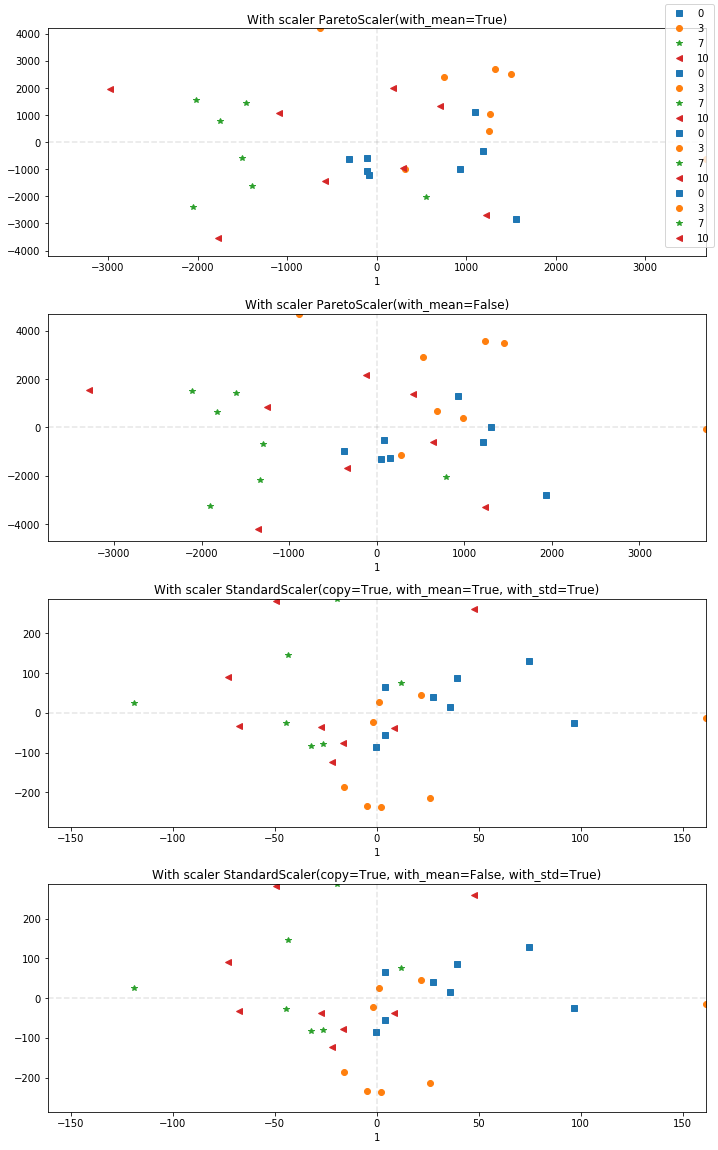

In [6]:
grid = ParameterGrid({
    'scaler': [
        modeling.ParetoScaler(with_mean=True),
        modeling.ParetoScaler(with_mean=False),
        StandardScaler(with_mean=True),
        StandardScaler(with_mean=False),
    ]
})

fig, axes = plt.subplots(len(grid), figsize=(10, 16))

for idx, params in enumerate(grid):
    mod_clone = clone(mod, safe=True).set_params(**params)
    hnmr_decompose = (
        pd.DataFrame(mod_clone.fit_transform(hnmr_spectra.T))
        .assign(label=target)
    )

    ax = plot_pca(hnmr_decompose, axes[idx])
    ax.set_title(f'With scaler {params["scaler"]}')    

fig.legend()
fig.tight_layout()